# Zillow- Final Report

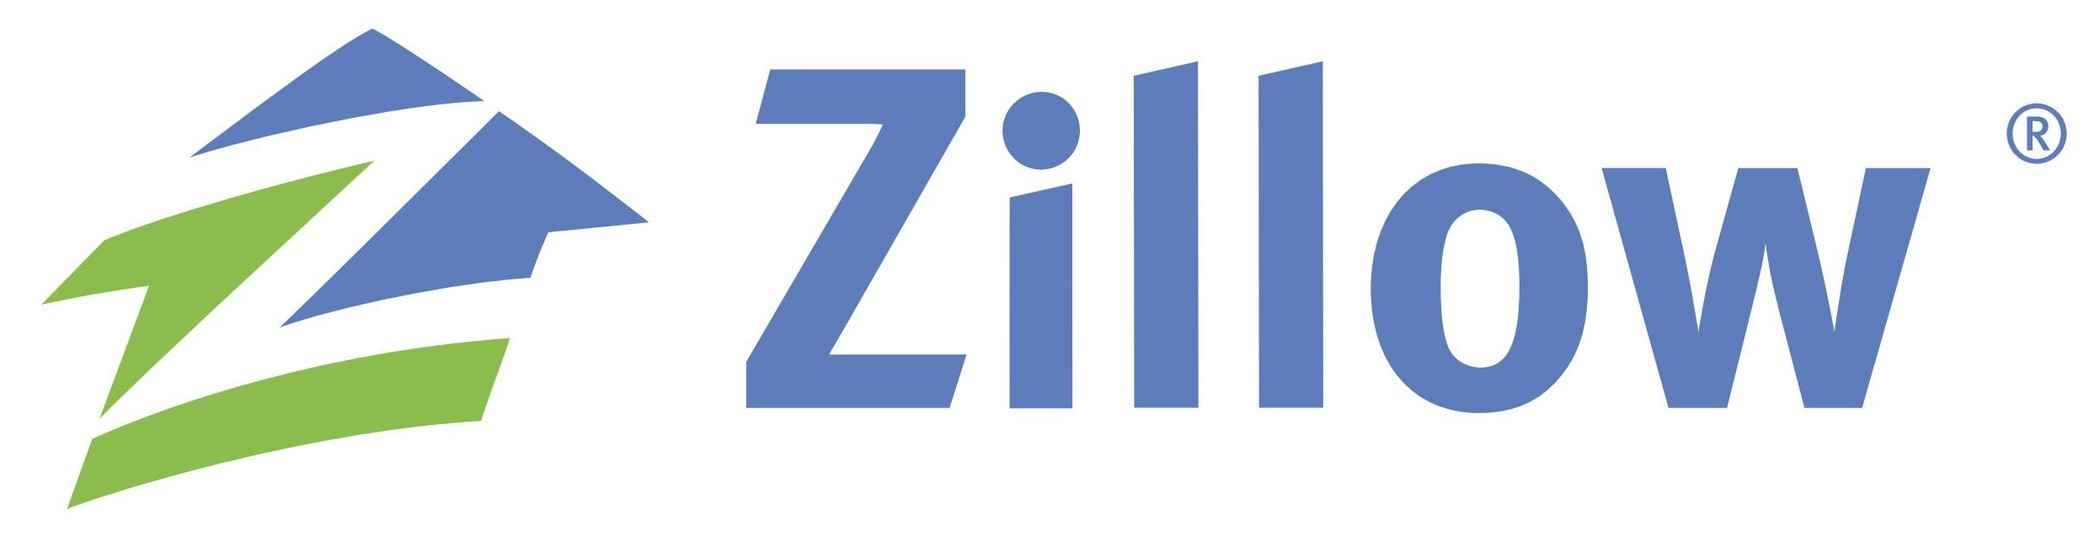

This is the exploratory element of the Zillow 2017 predictions dataset.  This is the first document, which is accompanied by the modeling notebook and final report notebook.   

## Purpose
The purpose of this notebook is to explore the data to identify which variables are primarily responsible for the changes in home prices from the data set.

### Goal/Aim
 - Your goal is to predict the values of single unit properties using the observations from 2017.
 - Find which features variable pairs impact values
 - Find which categorical and continuous variables impact value
 - Build regression models to meet stakeholder questions
 - Compare models and select best performing model

## Methodology
#### Acquire and Wrangle
- Pull data in and adjust to meet needs of EDA and modeling
#### EDA
- Look at individual variables (univariate analysis) (in zillow-eda-modeling report)
- Look at variables compared to each other (bivariate analysis)
- Look at all variables compared to all other variables (multivariate analysis)
#### Modeling
- Using scaled data, use multiple regression models to evaluate
- compare models 
- Select best performing model and use it on test data

# Setup

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply


## Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths
import wrangle
import explore
import model
import imports
import os

import warnings
warnings.filterwarnings("ignore")

# Import local libraries

# Acquire and Wrangle
 - Data is imported via python from the CodeUp SQL database.  See data Dictionary for data imported.
 - Approximately 50,000 Rows of data was returned
 - Data was wrangled and prepared by:
     - Renaming columns via SQL
     - Filling NaN values in the garage and pool
     - Dropping other NAN values
     - Creating additional features
         - Age (2017 - year_built)
         - Living space (square_foot of house - (average bathroom size*number of bathrooms + average bedroom size * number of bedrooms)
     - Outliers removed
         - Homes with more than 6 bedrooms or bathrooms
         - Homes over $2M 
         - Homes with over 4 garages
     - Changed data types
         - Converted many columns to integer

In [3]:
# Acquire and wrangle from wrangle.py file
df = wrangle.wrangle_zillow()
df.shape

Using cached csv


(50444, 12)

In [4]:
# Adding county name function
def get_locations_from_fed_code(fip):
    if int(fip) == 6037:
        return "LA County"
    if int(fip) == 6059:
        return "Orange County"
    if int(fip) == 6111:
        return "Ventura County"

In [5]:
# Adding function to df and seeing shape
df["county"] = np.select([df.fed_code == 6037, df.fed_code==6059, df.fed_code == 6111],["LA County", "Orange County", "Ventura County"])
df["county"] = df.fed_code.apply(lambda x: get_locations_from_fed_code(x))
df.county.value_counts(), df.shape

(LA County         32549
 Orange County     13601
 Ventura County     4294
 Name: county, dtype: int64,
 (50444, 13))

In [6]:
#Splitting Data
train, validate, test = wrangle.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


### Exploring Drivers
1. Find which features variable pairs impact values?
     - What's the role of location (counties) in value?
     - How does space affect value?
     - What's the relationship between age, square_feet, age, and value (Continuous variables)

#### 1. First look at counties as Driver

Generating plots tax_value by county


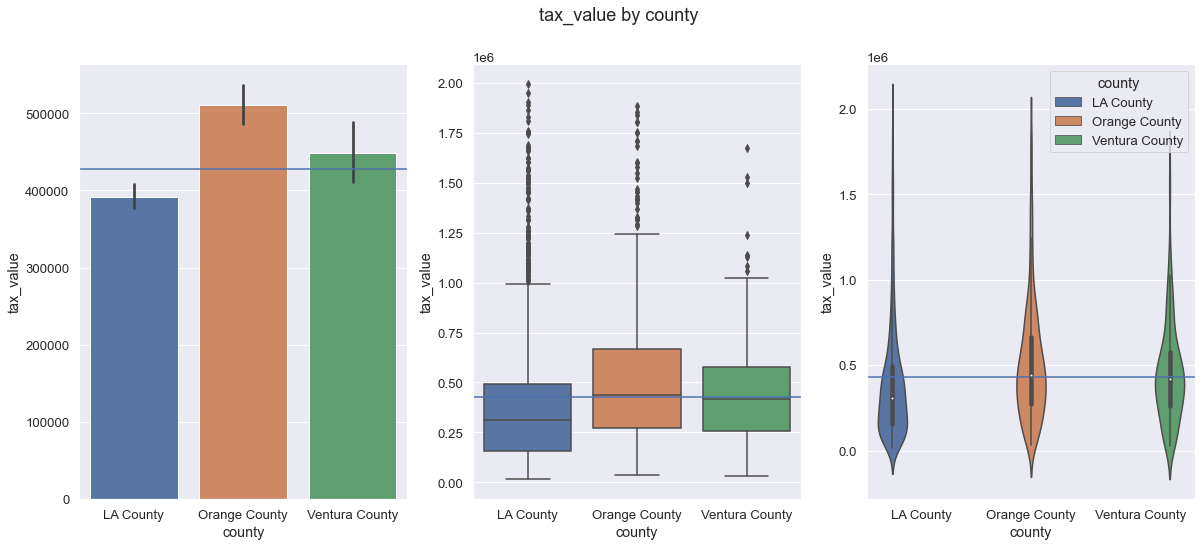

In [7]:
# Using explore file to build bar, box and violin charts based on county and tax value
explore.plot_categorical_and_continuous_vars(train, ['county'], ['tax_value'], sample_amt = 2500)

#### Statistical test to accompany Visual (t-test)

In [8]:
# Perform a 1 sample t-test for each county's tax value vs overall tax value mean
alpha = 0.05
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    if (p/2 < alpha) and (t>0):
        print(county, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    
    if (p/2 < alpha) and (t<0):
        print(county, round(t,2), "Significantly Less")

LA County -15.39 Significantly Less
Orange County  t:  19.73 Significantly Greater
Ventura County  t:  6.37 Significantly Greater


#### 2. How does space affect value? (Pearson-R correlation)

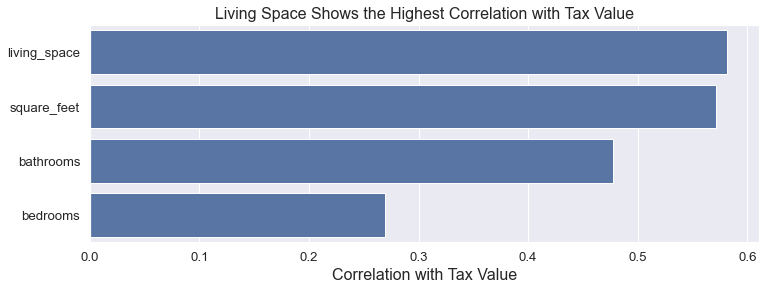

In [9]:
# Plot correlation of living space features to tax value. 
# Used pandas correlation method but also did scipy correlation and proved significant
of_interest = ['tax_value','living_space','square_feet','bathrooms','bedrooms']
corrs = pd.DataFrame(train[of_interest].drop(columns = ['tax_value']).corrwith(train.tax_value, method = 'pearson').sort_values(ascending=False), columns = ["Correlation"])
plt.figure(figsize = (12,4))
sns.barplot(data = corrs, y = corrs.index, x = corrs.Correlation, color = 'b')
plt.xlabel("Correlation with Tax Value", fontsize = 16)
p=plt.title("Living Space Shows the Highest Correlation with Tax Value", fontsize = 16)

#### Relationship between continuous variables - looking specifically at tax_value

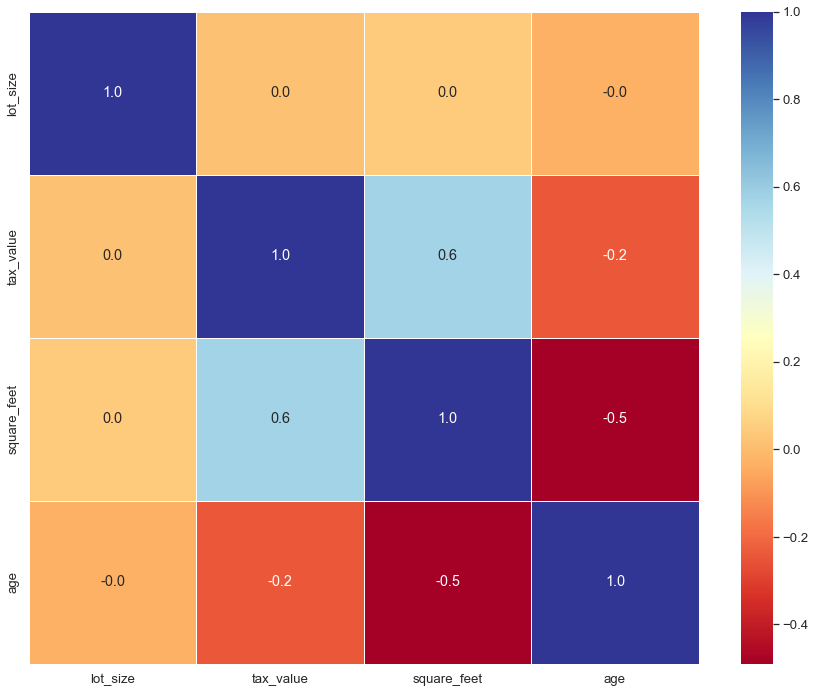

In [10]:
# Using continuous variables to build Chi2 correlation heatmap
train_continuous = train[['square_feet','lot_size', 'tax_value','age']]
# Chi2 Test test up
chi2, p, degf, expected = stats.chi2_contingency(train_continuous)
results = pd.DataFrame(columns=['Features','Chi2Weights'])
# Loop for continuous Columns
for i in range (len(train_continuous.columns)):
    chi2, p = stats.chisquare(train_continuous[train_continuous.columns[i]])
    results = results.append([pd.Series([train_continuous.columns[i], chi2], index=results.columns)], ignore_index = True)
results = results.sort_values(by = "Chi2Weights", ascending = False)
# results.head(20)
# Creating Chi2 df for visual
chi_df = train[results["Features"].head(20)]
#chi_df.head()
# Finding Correlation - Need to limit to continuous variables only
# Visualize continuous variables
plt.figure(figsize = (15, 12))
sns.heatmap(chi_df.corr(), cmap="RdYlBu", annot=True, linewidth=0.5, fmt=".1f")

plt.show()

### Algorithm feature selection

In [11]:
# train on feature selection  
X = train[['bedrooms', 'bathrooms', 'square_feet', 'garage', 'pool',
       'lot_size', 'year_built','fed_code','living_space']]
y= train.tax_value


In [12]:
#kbest
model.select_kbest(X, y, 3)

['bathrooms', 'square_feet', 'living_space']

In [13]:
# RFE
model.rfe(X,y,3)

['bathrooms', 'garage', 'pool']

### Algorithm features based on scaled train data

In [14]:
# Functions for Modeling/Ranking
# Functions are in explore and Modeling files, but error when pulling in because they reference each other.
def model_feature_selection(train, validate, test, to_dummy, features_to_scale, columns_to_use):
    """ Performs scaling and feature selection using recursive feature elimination. Performs operations on all three inputed data sets. Requires lists of features to encode (dummy), features to scale, and columns (features) to input to the feature elimination. """
    
    # Gets dummy variables
    X_train_exp = pd.get_dummies(train, columns = to_dummy, drop_first=True)
    
    # Gets dummy variables for validate and test sets as well for later use
    X_train = X_train_exp[columns_to_use]
    X_validate = pd.get_dummies(validate, columns = to_dummy, drop_first=True)[columns_to_use]
    X_test = pd.get_dummies(test, columns = to_dummy, drop_first=True)[columns_to_use]
    
    # Scale train, validate, and test sets using the scale_data function from wrangle.pu
    X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.scale_data2(X_train, X_validate, X_test,features_to_scale, scaler_type)
    
    # Set up the dependent variable in a datafrane
    y_train = train[['tax_value']]
    y_validate = validate[['tax_value']]
    y_test = test[['tax_value']]
    
    # Perform Feature Selection using Recursive Feature Elimination
    # Initialize ML algorithm
    lm = LinearRegression()
    # create RFE object - selects top 3 features only
    rfe = RFE(lm, n_features_to_select=3)
    # fit the data using RFE
    rfe.fit(X_train_scaled, y_train)
    # get mask of columns selected
    feature_mask = rfe.support_
    # get list of column names
    rfe_features = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    # view list of columns and their ranking

    # get the ranks
    var_ranks = rfe.ranking_
    # get the variable names
    var_names = X_train_scaled.columns.tolist()
    # combine ranks and names into a df for clean viewing
    rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    # sort the df by rank
    rfe_ranks_df.sort_values('Rank')

    return X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features
    
def model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features, show_test = False, print_results = True):
    """ Fits data to different regression algorithms and evaluates on validate (and test if desired for final product). Outputs metrics for each algorithm (r2, rmse) as a Pandas DataFrame. """
    
    ### BASELINE
    
    # 1. Predict tax_value_pred_mean
    tax_value_pred_mean = y_train['tax_value'].mean()
    y_train['tax_value_pred_mean'] = tax_value_pred_mean
    y_validate['tax_value_pred_mean'] = tax_value_pred_mean

    # 2. compute tax_value_pred_median
    tax_value_pred_median = y_train['tax_value'].median()
    y_train['tax_value_pred_median'] = tax_value_pred_median
    y_validate['tax_value_pred_median'] = tax_value_pred_median

    # 3. RMSE of tax_value_pred_mean
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)
    if print_results:
        print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
          "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

    # 4. RMSE of tax_value_pred_median
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

    if print_results:

        print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
          "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

    ### OLS Linear Regression
    
    # create the model object
    lm = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm.fit(X_train_scaled, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

    # predict validate
    y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

    if print_results:
        print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)
    
    # predict test
    if show_test:
        
        y_test['tax_value_pred_lm'] = lm.predict(X_test_scaled)
        rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

    # Lasso-Lars
    
    # create the model object
    lars = LassoLars(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lars.fit(X_train_scaled, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

    # predict validate
    y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

    if print_results:

        print("RMSE for OLS using LarsLasso\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)

    # predict test
    if show_test:
        
        y_test['tax_value_pred_lars'] = lars.predict(X_test_scaled)
        rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lars)**(1/2)

    # Tweedie
    
    # create the model object
    glm = TweedieRegressor(power=1, alpha=0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm.fit(X_train_scaled, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

    # predict validate
    y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)
    
    if print_results:
        print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)
        
    # predict test
    if show_test:
        
        y_test['tax_value_pred_glm'] = glm.predict(X_test_scaled)
        rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_glm)**(1/2)

    # Polynomial features
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2,interaction_only=True)

    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train_scaled)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(X_validate_scaled)
    X_test_degree2 = pf.transform(X_test_scaled)
    
    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.tax_value)

    # predict train
    y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

    # predict validate
    y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)
    
    if print_results:
        print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)
        
    # predict test
    if show_test:
        
        y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)
        rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

    results = pd.concat([
    y_validate.apply(lambda col: r2_score(y_validate.tax_value, col)).rename('r2'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.tax_value, col)).rename('mse'),
    ], axis=1).assign(
        rmse=lambda df: df.mse.apply(lambda x: x**0.5)
    )
    if show_test:
        results = pd.concat([
        y_train.apply(lambda col: r2_score(y_train.tax_value, col)).rename('r2_train'),
        y_train.apply(lambda col: mean_squared_error(y_train.tax_value, col)).rename('mse_train'),
        y_validate.apply(lambda col: r2_score(y_validate.tax_value, col)).rename('r2_validate'),
        y_validate.apply(lambda col: mean_squared_error(y_validate.tax_value, col)).rename('mse_validate'),
        y_test.apply(lambda col: r2_score(y_test.tax_value, col)).rename('r2_test'),
        y_test.apply(lambda col: mean_squared_error(y_test.tax_value, col)).rename('mse_test'),
        ], axis=1).assign(
            rmse_validate=lambda df: df.mse_validate.apply(lambda x: x**0.5)
        )
        
        results = results.assign(rmse_train= lambda results: results.mse_train.apply(lambda x: x**0.5))
        results = results.assign(rmse_test= lambda results: results.mse_test.apply(lambda x: x**0.5))

In [15]:
# To be encoded
to_dummy = ['county']
# Features to be scaled
features_to_scale = ['bedrooms', 'bathrooms', 'square_feet', 'garage', 'pool', 'lot_size','age','living_space']
# Features fed into model based on exploration
columns_to_use = ['bedrooms', 'bathrooms', 'square_feet', 'garage', 'pool', 'lot_size', 'year_built',
                  'fed_code', 'age','living_space']

In [16]:
# Defining and Scaling Variables for RFE Ranking
# Test all counties together    
train_sample = train
validate_sample = validate
test_sample = test
scaler_type = "MinMaxScaler"

X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features = model_feature_selection(train_sample, validate_sample, test_sample, to_dummy, features_to_scale, columns_to_use)

print(rfe_features)
# all_results.append(model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features))

Invalid scaler entry, using MinMax
['bedrooms_scaled', 'square_feet_scaled', 'living_space_scaled']


In [17]:
# RFE Ranking
# Perform Feature Selection using Recursive Feature Elimination
# Initialize ML algorithm
lm = LinearRegression()
# create RFE object - selects top 3 features only
rfe = RFE(lm, n_features_to_select=3)
# fit the data using RFE
rfe.fit(X_train_scaled, y_train)
# get mask of columns selected
feature_mask = rfe.support_
# get list of column names
rfe_features = X_train_scaled.iloc[:,feature_mask].columns.tolist()
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
2,bedrooms_scaled,1
4,square_feet_scaled,1
9,living_space_scaled,1
3,bathrooms_scaled,2
7,lot_size_scaled,3
5,garage_scaled,4
6,pool_scaled,5
0,year_built,6
1,fed_code,7
8,age_scaled,8


# EDA Takeaway
- Counties could be separate analysis
- Living_space, Square_feet, bedrooms, and bathrooms have strongest impact on tax_value
- Algorithms also include Garage and pools
- County and Garage features are highly correlated

# Modeling


In [18]:
# Test all counties together    
train_sample = train
validate_sample = validate
test_sample = test

X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features = model_feature_selection(train_sample, validate_sample, test_sample, to_dummy, features_to_scale, columns_to_use)

print(rfe_features)
# all_results.append(model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features))

Invalid scaler entry, using MinMax
['bedrooms_scaled', 'square_feet_scaled', 'living_space_scaled']


### Baseline Creation

In [19]:
# 1. Predict tax_value_pred_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  352324.75 
Validate/Out-of-Sample:  357931.84
RMSE using Median
Train/In-Sample:  361008.51 
Validate/Out-of-Sample:  367543.49


#### Linear Regresssion Model (OLS)

In [20]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  283359.14753804513 
Validation/Out-of-Sample:  283209.1818831278


#### LassoLars

In [21]:
# create the model object
lars = LassoLars(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using LarsLasso\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LarsLasso
Training/In-Sample:  283366.64646182227 
Validation/Out-of-Sample:  283239.1783657545


#### Tweedie

In [22]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  352324.7463170989 
Validation/Out-of-Sample:  357931.835656096


#### Polynomial

In [23]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2,interaction_only=False)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  276283.14347368566 
Validation/Out-of-Sample:  277526.508084012


#### Visual to compare Models

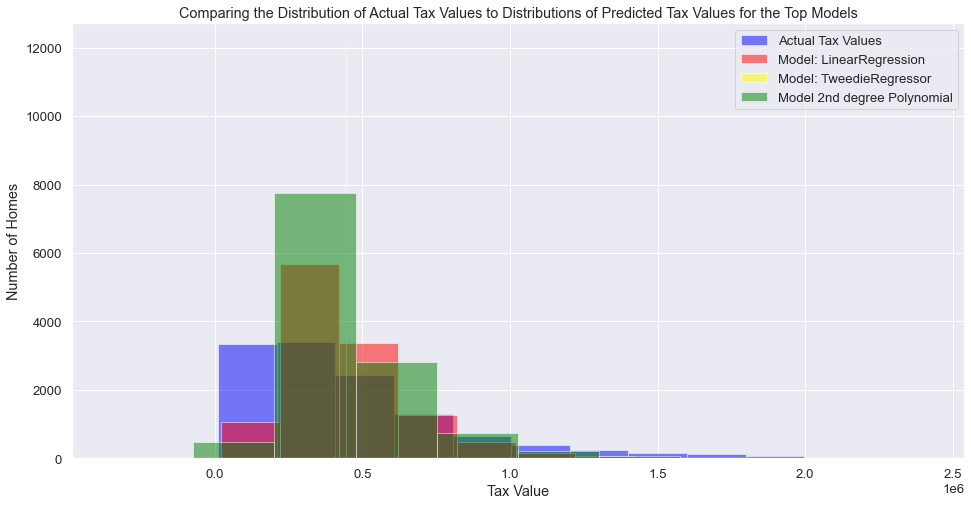

In [24]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

#### Metrics to evaluate Model

In [25]:
pd.concat([
    y_validate.apply(lambda col: r2_score(y_validate.tax_value, col)).rename('r2'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.tax_value, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(lambda x: x**0.5)
)

,r2,mse,rmse
tax_value,1.000000,0.000000e+00,0.000000
tax_value_pred_mean,-0.000191,1.281152e+11,357931.835656
tax_value_pred_median,-0.054629,1.350882e+11,367543.487105
tax_value_pred_lm,0.373823,8.020744e+10,283209.181883
tax_value_pred_lars,0.373691,8.022443e+10,283239.178366
tax_value_pred_glm,-0.000191,1.281152e+11,357931.835656
tax_value_pred_lm2,0.398700,7.702096e+10,277526.508084


In [26]:
X_train_exp = pd.get_dummies(train, columns = to_dummy, drop_first=True)
X_train = X_train_exp[columns_to_use]
X_validate = pd.get_dummies(validate, columns = to_dummy, drop_first=True)[columns_to_use]
X_test = pd.get_dummies(test, columns = to_dummy, drop_first=True)[columns_to_use]

### Test on Polynomial.
- Highest R2 score
- Lowest RMSE score

In [27]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our test data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test, y_test.tax_value)

# predict test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)


print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Test/Out-of-Sample:  284716.58174629207
